In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pylab
from scipy.signal import dfreqresp
from sklearn.model_selection import train_test_split
# from visualize_clf import visualize_clf
from plot3d import plot3d
from test_lr import test_lr
from prepare import prepare_data, preprocess_data

params = {'xtick.labelsize': 18,
'ytick.labelsize': 18,
'axes.titlesize' : 22,
'axes.labelsize' : 20,
'legend.fontsize': 18,
'legend.title_fontsize': 22,
'figure.titlesize': 24 }
pylab.rcParams.update(params)

In [2]:
from verify_gradients import compare_gradients
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_validate
from LinearRegressor import LinearRegressor
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

## Preliminary: Updated Data Loading

In [3]:

virus_data = pd.read_csv('data_HW3.csv')

raw_train_df, raw_test_df = train_test_split(virus_data, test_size = 0.2, random_state = 134)
raw_train_df, raw_test_df = preprocess_data(raw_train_df), preprocess_data(raw_test_df)

# Prepare training set according to itself
train_df = prepare_data(raw_train_df, raw_train_df)

# Prepare test set according to the raw training set
test_df = prepare_data(raw_train_df, raw_test_df)

## Section 1: Linear regression implementation

In [4]:

sub_train_df, val_df = train_test_split(train_df, test_size = 0.2, random_state = 134)
target = 'contamination_level'

# x_train = sub_train_df.filter(regex= '^PCR').to_numpy()
x_train = sub_train_df.drop(columns = [target]).to_numpy()
y_train = sub_train_df['contamination_level']

# x_val = val_df.filter(regex= '^PCR').to_numpy()
x_val = val_df.drop(columns = [target]).to_numpy()
y_val = val_df['contamination_level']

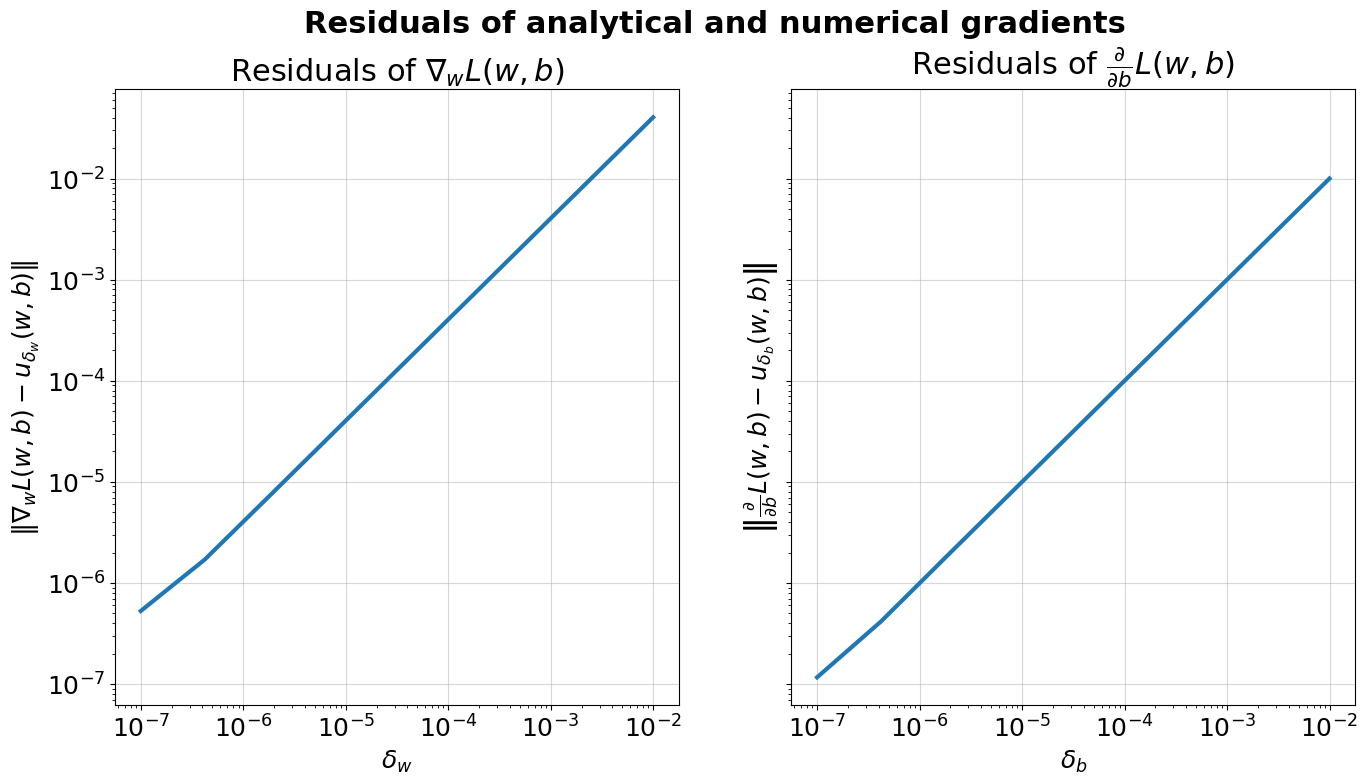

In [5]:
compare_gradients(x_train, y_train, deltas=np.logspace(-7, -2, 9))


lr size = 1e-09, Best train loss = 4.922888388224473, Best validation loss = 4.686510931873915
lr size = 1e-08, Best train loss = 4.9226857345355475, Best validation loss = 4.686320730103776
lr size = 1e-07, Best train loss = 4.920660357775808, Best validation loss = 4.684419778886447
lr size = 1e-06, Best train loss = 4.900522116573466, Best validation loss = 4.665516464316247
lr size = 1e-05, Best train loss = 4.710221448341627, Best validation loss = 4.4866669835605455
lr size = 0.0001, Best train loss = 3.5666781595768824, Best validation loss = 3.3948482754553932
lr size = 0.001, Best train loss = 2.6551526940045505, Best validation loss = 2.36033414015088
lr size = 0.01, Best train loss = 2.5987022750764406, Best validation loss = 2.255202656045101
lr size = 0.1, Best train loss = 2.6261340492627405, Best validation loss = 2.201144030333895


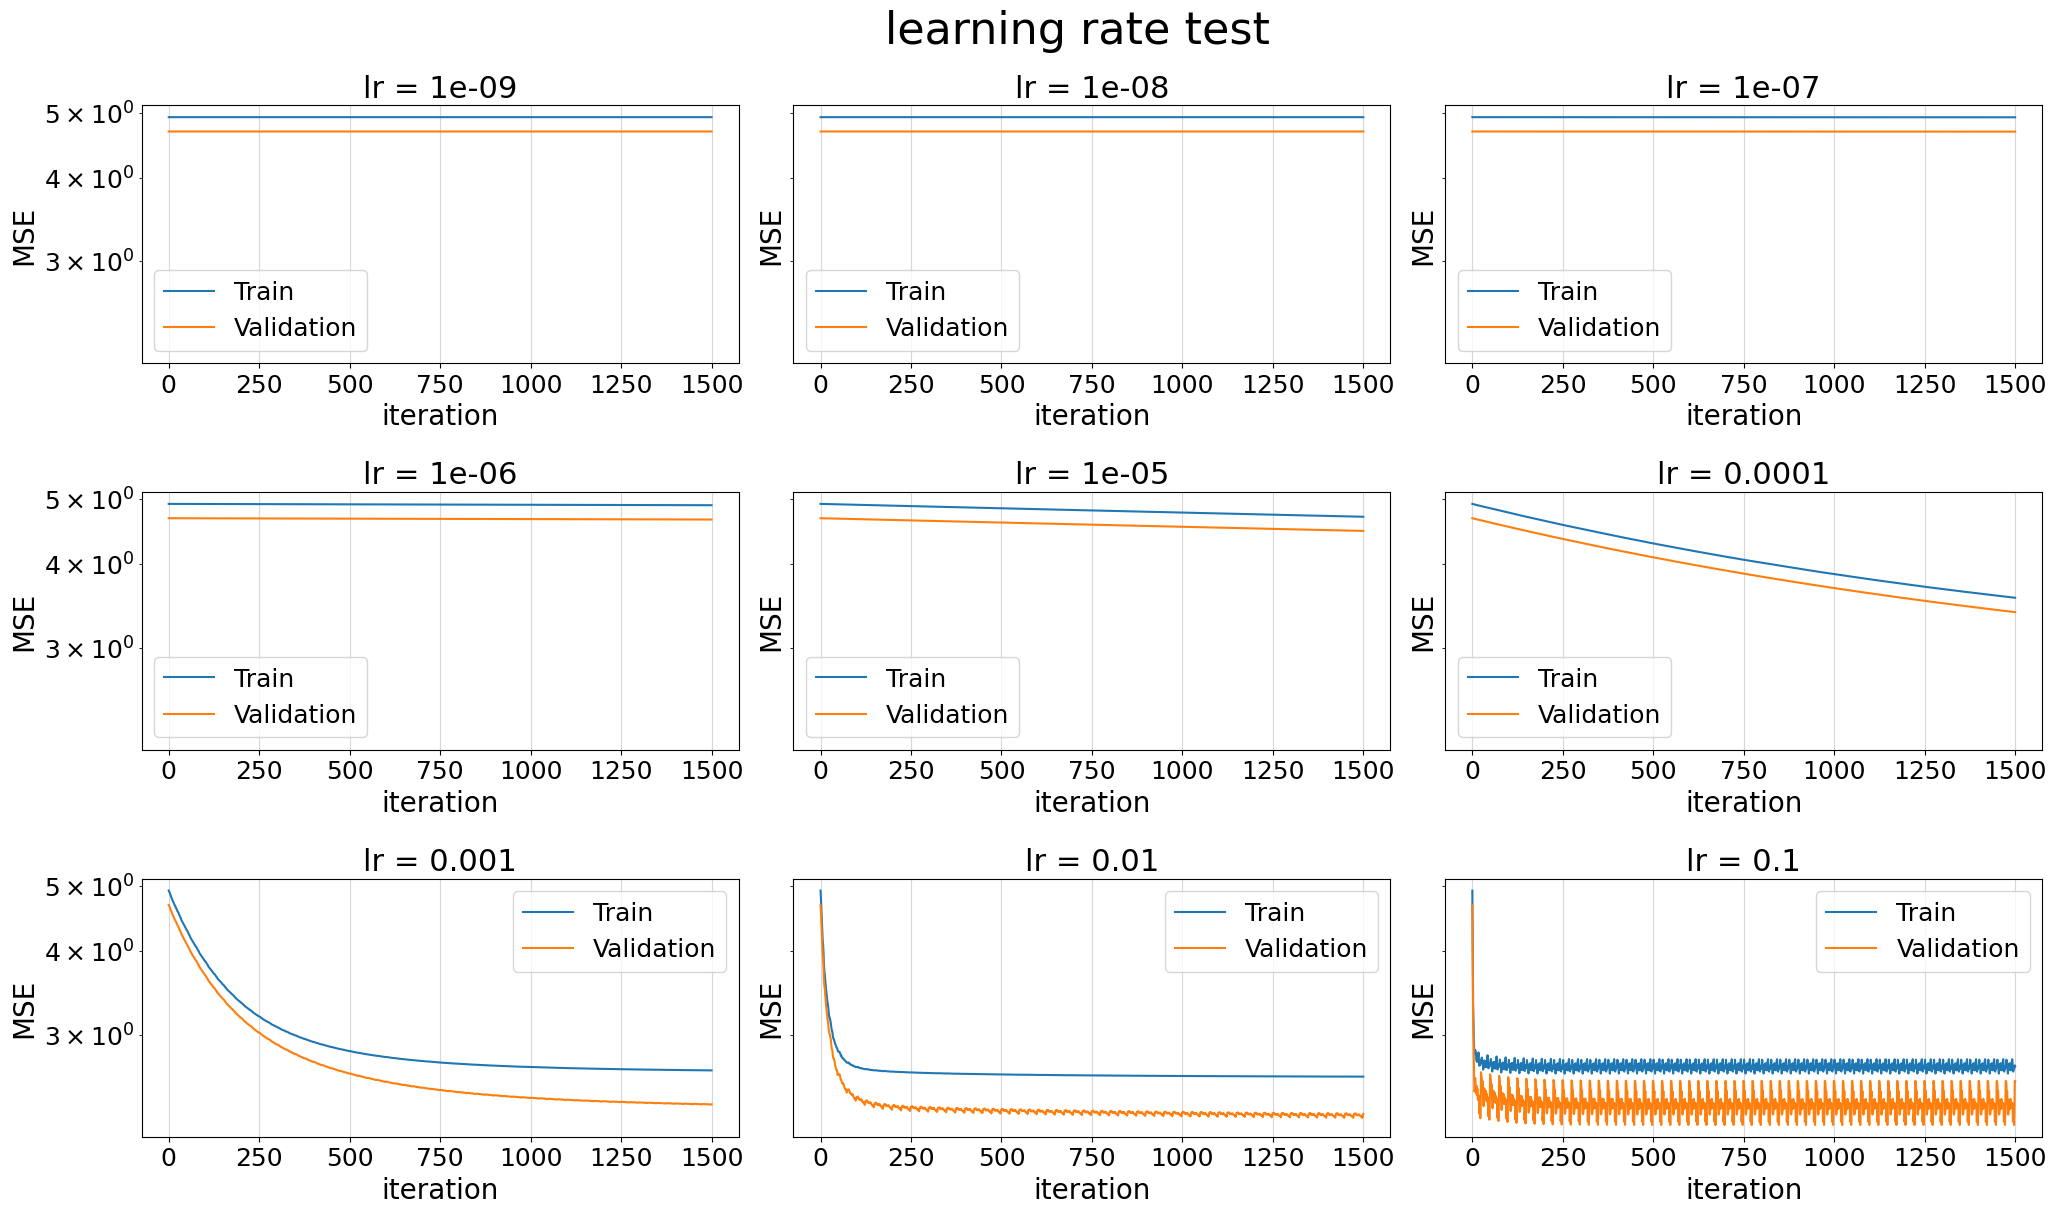

In [6]:
test_lr(x_train, y_train, x_val, y_val, title= 'learning rate test')

## Section 2: Evaluation and Baseline

In [7]:
target = 'contamination_level'

# x_train = train_df.filter(regex= '^PCR').to_numpy()
x_train = train_df.drop(columns = [target]).to_numpy()
y_train = train_df['contamination_level']

# x_test = test_df.filter(regex= '^PCR').to_numpy()
x_test = test_df.drop(columns = [target]).to_numpy()
y_test = test_df['contamination_level']

In [8]:
# x_train = raw_train_df.drop(columns = [target]).to_numpy()
# y_train = raw_train_df['contamination_level']

# x_test = raw_test_df.drop(columns = [target]).to_numpy()
# y_test = raw_test_df['contamination_level']


In [9]:
dummy_regr = DummyRegressor(strategy="mean")

result = cross_validate(dummy_regr, x_train, y_train, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
# result = cross_validate(dummy_regr, x_train, y_train, cv=5, scoring='r2', return_train_score=True)

train_score = np.mean(result['train_score'])
val_score = np.mean(result['test_score'])

print(f"Train score: {train_score}")
print(f"Val score: {val_score}")

dummy_validation_score = val_score




Train score: -3.7273901679144807
Val score: -3.738034830111405


In [10]:
fitted_dummy = dummy_regr.fit(x_train, y_train)

#### Basic hyperparameter tuning

In [11]:
values = np.logspace(-9, -1, 9)

train_scores =[]
validation_scores = []
max_score = dict(lr=0,train_score=0, max_validation_score=-100)
dummy_val_scores = np.ones(len(values)) * dummy_validation_score

for lr in values:
    model = LinearRegressor(lr = lr)

    result = cross_validate(model, x_train, y_train, cv= 5, scoring= 'neg_mean_squared_error' ,return_train_score= True)
    train_score = np.mean(result['train_score'])
    validation_score = np.mean(result['test_score'])

    train_scores.append(train_score)
    validation_scores.append(validation_score)


    if validation_score > max_score['max_validation_score']:
        max_score['lr'] = lr
        max_score['train_score'] = train_score
        max_score['max_validation_score'] = validation_score

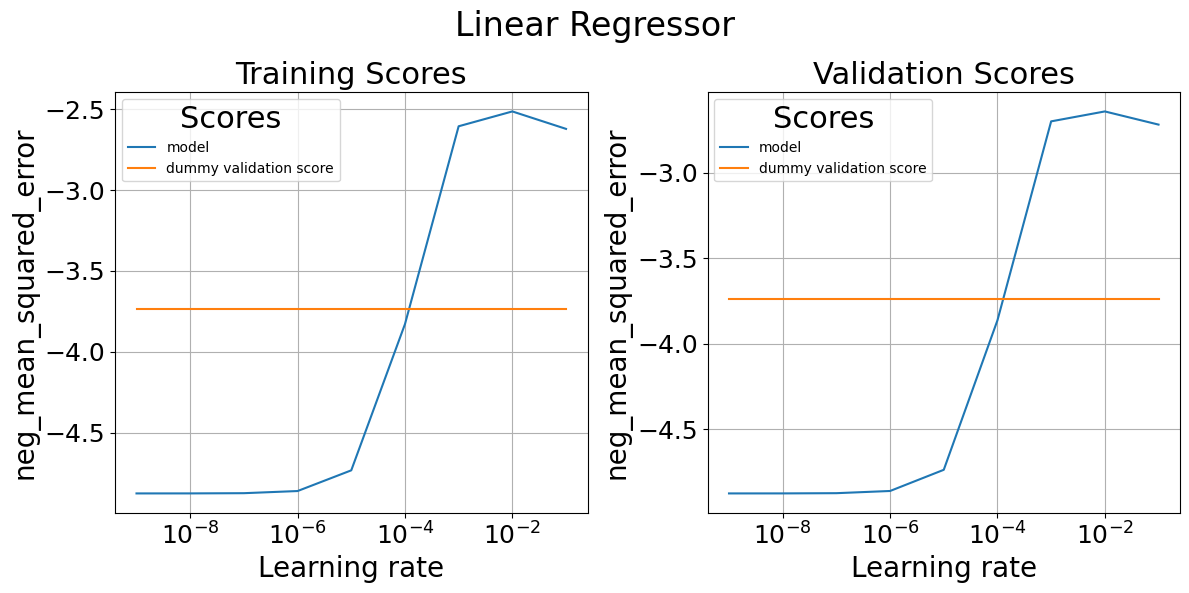

In [12]:

fig, ax = plt.subplots(1,2, figsize=(12, 6))  

fig.suptitle('Linear Regressor', fontsize=24)
ax[0].semilogx(values, train_scores, label='model')
ax[0].semilogx(values, dummy_val_scores, label='dummy validation score')
ax[0].set_xlabel('Learning rate')
ax[0].set_ylabel('neg_mean_squared_error')
ax[0].set_title('Training Scores')
ax[0].grid(True)
ax[0].legend(fontsize=10, title='Scores')

ax[1].semilogx(values, validation_scores, label='model')
ax[1].semilogx(values, dummy_val_scores, label='dummy validation score')
ax[1].set_xlabel('Learning rate')
ax[1].set_ylabel('neg_mean_squared_error')
ax[1].set_title('Validation Scores')
ax[1].grid(True)
ax[1].legend(fontsize=10, title='Scores')

plt.tight_layout()
plt.show()


In [13]:
print(max_score)

{'lr': 0.01, 'train_score': -2.5137416010283564, 'max_validation_score': -2.6420573935793157}


In [14]:
fitted_linear = LinearRegressor(lr = max_score['lr']).fit(x_train, y_train)

In [15]:
test_score = fitted_linear.score(x_test, y_test)

## Section 3: Lasso linear regression


In [16]:

values = np.logspace(-9, 0, 10)

train_scores =[]
validation_scores = []
max_score = dict(lr=0,train_score=0, max_validation_score=-100)
dummy_val_scores = np.ones(len(values)) * dummy_validation_score

for reg in values:
    model = Lasso(alpha= reg, fit_intercept= True)

    result = cross_validate(model, x_train, y_train, cv= 5, scoring= 'neg_mean_squared_error' ,return_train_score= True)
    train_score = np.mean(result['train_score'])
    validation_score = np.mean(result['test_score'])

    train_scores.append(train_score)
    validation_scores.append(validation_score)


    if validation_score > max_score['max_validation_score']:
        max_score['lr'] = lr
        max_score['train_score'] = train_score
        max_score['max_validation_score'] = validation_score

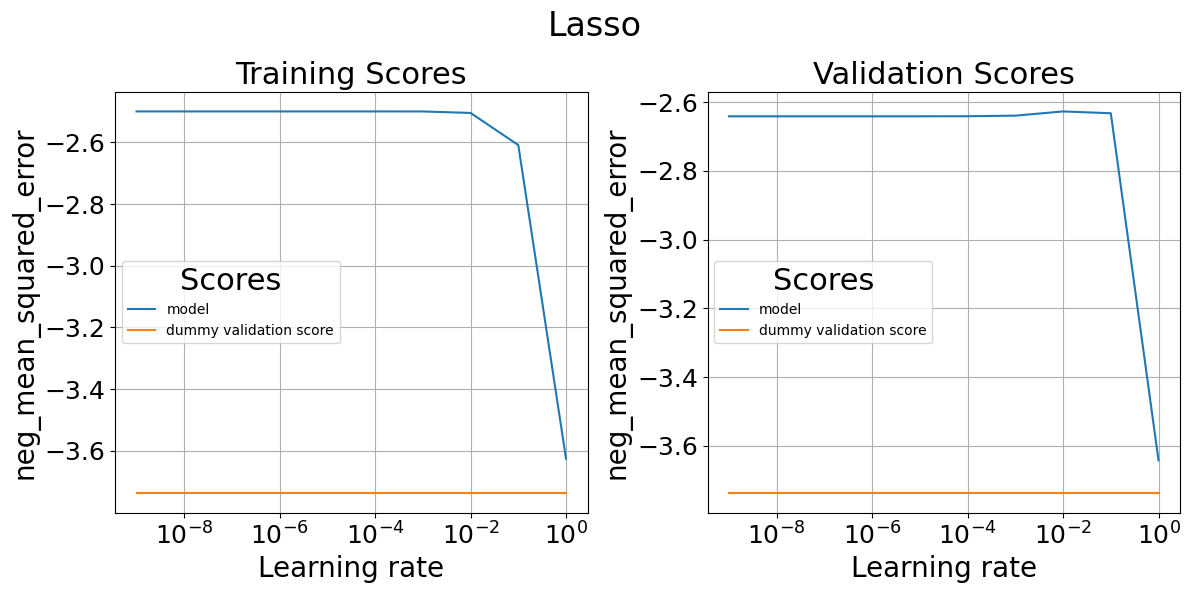

In [17]:

fig, ax = plt.subplots(1,2, figsize=(12, 6))  

fig.suptitle('Lasso', fontsize=24)
ax[0].semilogx(values, train_scores, label='model')
ax[0].semilogx(values, dummy_val_scores, label='dummy validation score')
ax[0].set_xlabel('Learning rate')
ax[0].set_ylabel('neg_mean_squared_error')
ax[0].set_title('Training Scores')
ax[0].grid(True)
ax[0].legend(fontsize=10, title='Scores')

ax[1].semilogx(values, validation_scores, label='model')
ax[1].semilogx(values, dummy_val_scores, label='dummy validation score')
ax[1].set_xlabel('Learning rate')
ax[1].set_ylabel('neg_mean_squared_error')
ax[1].set_title('Validation Scores')
ax[1].grid(True)
ax[1].legend(fontsize=10, title='Scores')

plt.tight_layout()
plt.show()

In [18]:
print(max_score)

{'lr': 0.1, 'train_score': -2.504702237730112, 'max_validation_score': -2.6270234067725053}


In [19]:
fitted_lasso = Lasso(alpha= max_score['lr'], fit_intercept= True).fit(x_train, y_train)

In [20]:
coef = fitted_lasso.coef_
coef_names = train_df.drop(columns = [target]).columns
coef_with_names = pd.DataFrame({'coef': coef, 'name': coef_names})
coef_with_names.sort_values(by='coef', key=abs, ascending=False, inplace= True)
print(coef_with_names.iloc[:5,:])

        coef             name
4   0.951464  happiness_score
11  0.072942           PCR_03
3  -0.026034  num_of_siblings
0  -0.000000              age
18  0.000000           PCR_10


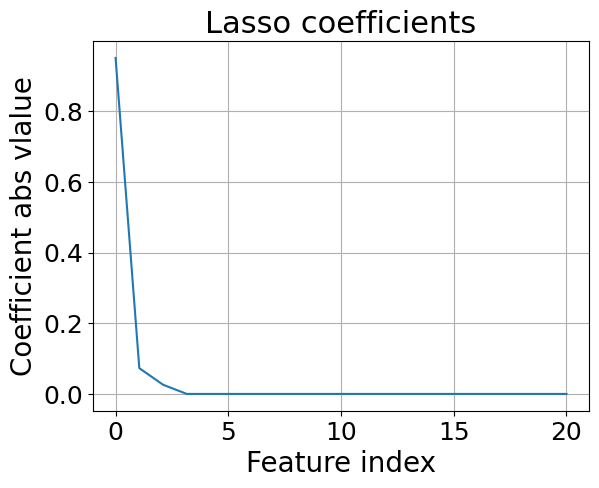

In [21]:
plt.plot(np.linspace(0, len(coef), len(coef)), coef_with_names['coef'].abs())
plt.xlabel('Feature index')
plt.ylabel('Coefficient abs vlalue')
plt.title('Lasso coefficients')
plt.grid(True)
plt.show()

## Section 4: Polynomial fitting (visualization)


In [22]:

poly_x_train = train_df[['PCR_03','PCR_07']].to_numpy()
poly_y_train = train_df['contamination_level']

poly_x_test = test_df[['PCR_03','PCR_07']].to_numpy()
poly_y_test = test_df['contamination_level']

c:\Users\matan\Desktop\Studies\IML\HW\hw3_wet\plot3d.py:28: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


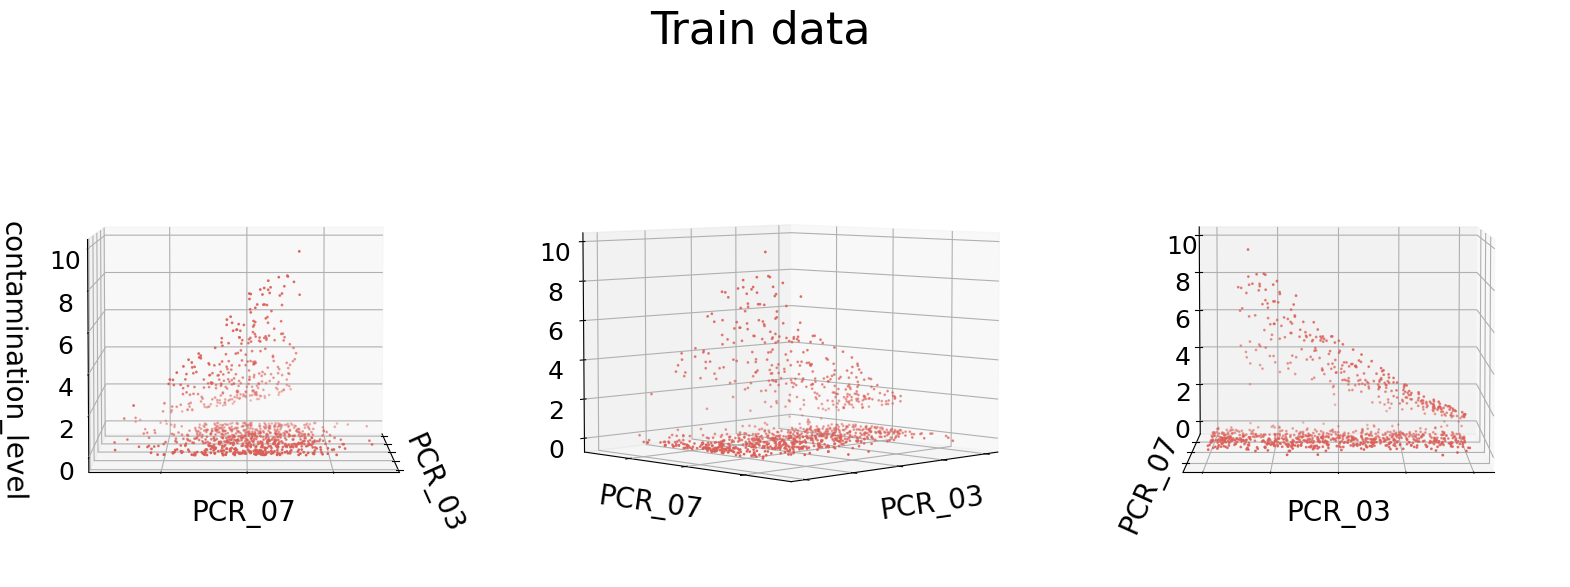

In [23]:
plot3d(train_df, 'PCR_03', 'PCR_07', 'contamination_level', 'Train data')

In [24]:

values = np.logspace(-9, 0, 10)

train_scores =[]
validation_scores = []
max_score = dict(lr=0,train_score=0, max_validation_score=-100)
dummy_val_scores = np.ones(len(values)) * dummy_validation_score

for reg in values:
    model = Pipeline([('feature_mapping', PolynomialFeatures(degree=3)),
    ('normalization', MinMaxScaler()),
    ('Lasso', Lasso(alpha= reg, fit_intercept=True))])

    result = cross_validate(model, poly_x_train, poly_y_train, cv= 5, scoring= 'neg_mean_squared_error' ,return_train_score= True)
    train_score = np.mean(result['train_score'])
    validation_score = np.mean(result['test_score'])

    train_scores.append(train_score)
    validation_scores.append(validation_score)


    if validation_score > max_score['max_validation_score']:
        max_score['lr'] = lr
        max_score['train_score'] = train_score
        max_score['max_validation_score'] = validation_score

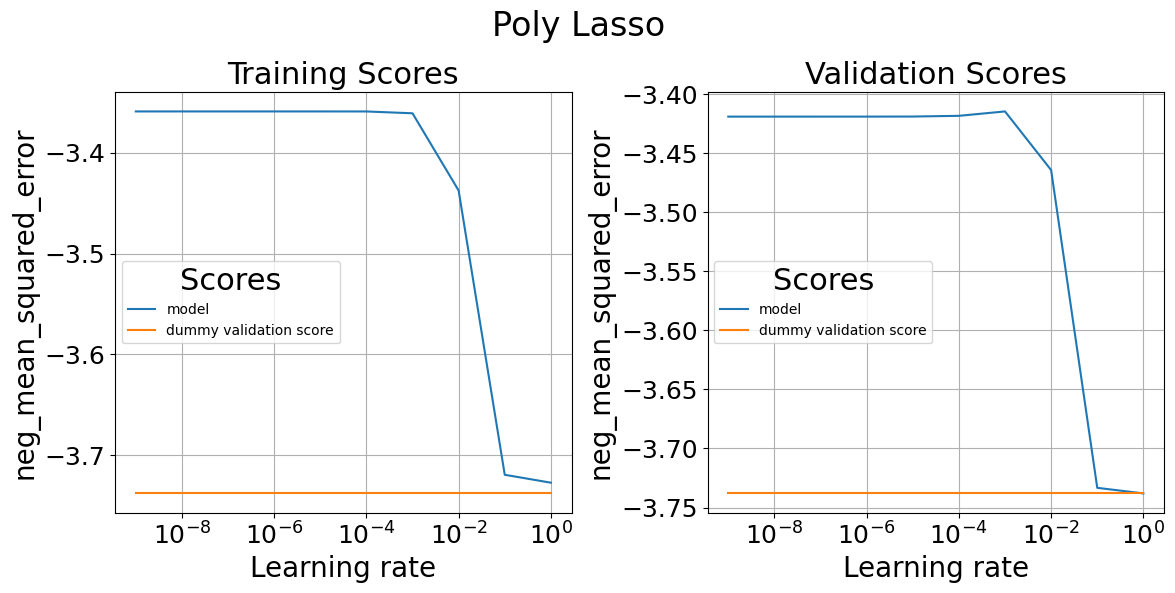

In [25]:

fig, ax = plt.subplots(1,2, figsize=(12, 6))  

fig.suptitle('Poly Lasso', fontsize=24)
ax[0].semilogx(values, train_scores, label='model')
ax[0].semilogx(values, dummy_val_scores, label='dummy validation score')
ax[0].set_xlabel('Learning rate')
ax[0].set_ylabel('neg_mean_squared_error')
ax[0].set_title('Training Scores')
ax[0].grid(True)
ax[0].legend(fontsize=10, title='Scores')

ax[1].semilogx(values, validation_scores, label='model')
ax[1].semilogx(values, dummy_val_scores, label='dummy validation score')
ax[1].set_xlabel('Learning rate')
ax[1].set_ylabel('neg_mean_squared_error')
ax[1].set_title('Validation Scores')
ax[1].grid(True)
ax[1].legend(fontsize=10, title='Scores')

plt.tight_layout()
plt.show()

In [26]:
print(max_score)

{'lr': 0.1, 'train_score': -3.3608295890931643, 'max_validation_score': -3.414752168222834}


In [27]:
fitted_poly_lasso = Pipeline([('feature_mapping', PolynomialFeatures(degree=3)), ('normalization', MinMaxScaler()), ('Lasso', Lasso(alpha= max_score['lr'], fit_intercept=True))]).fit(poly_x_train, poly_y_train)

c:\Users\matan\Desktop\Studies\IML\HW\hw3_wet\plot3d.py:28: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


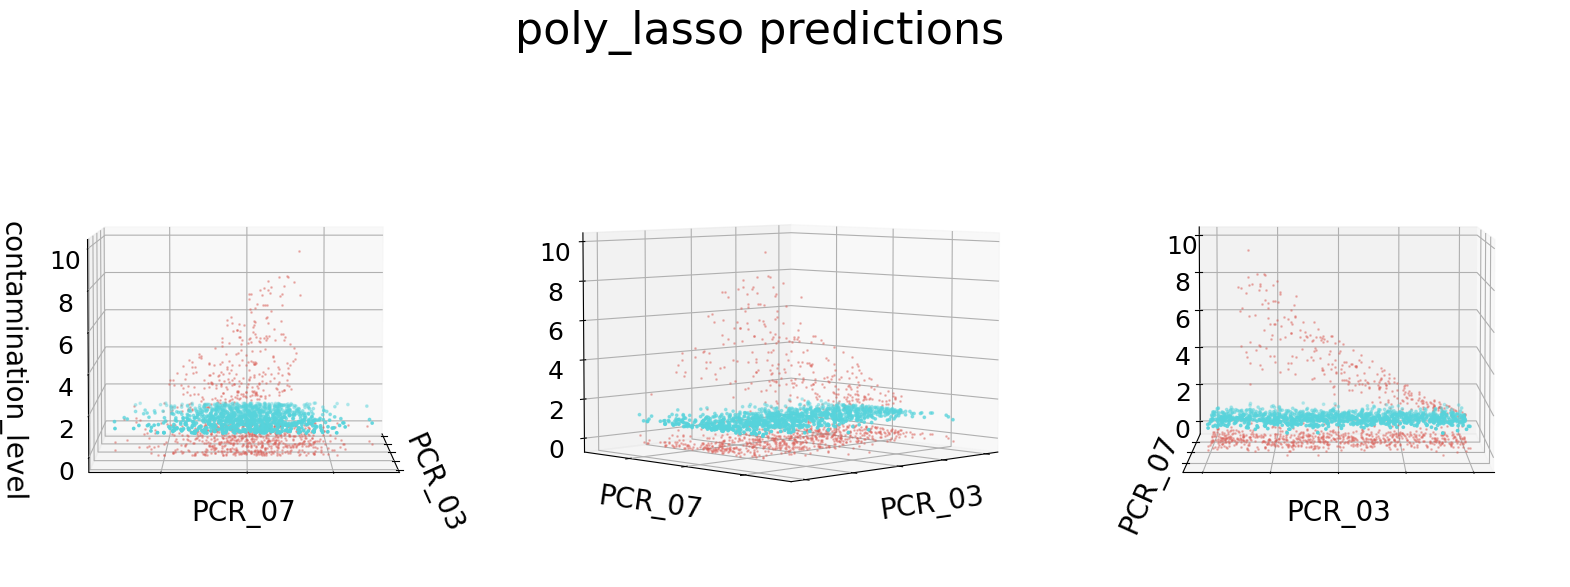

In [28]:
predictons = fitted_poly_lasso.predict(poly_x_train)
plot3d(train_df, 'PCR_03', 'PCR_07', 'contamination_level', 'poly_lasso predictions', predictions=predictons)

## Section 5: Fitting Gradient Boosted Machines (GBM) of the CovidScore


In [29]:
# TODO create new train and test sets with relevant features.
target = 'contamination_level'

x_train = train_df.drop(columns = [target]).to_numpy()
y_train = train_df['contamination_level']

x_test = test_df.drop(columns = [target]).to_numpy()
y_test = test_df['contamination_level']

In [37]:
learning_rates = np.logspace(-7, 0, 8)
min_samples_leaf = range(1, 50, 5)

params = {'learning_rate': learning_rates, 'min_samples_leaf': min_samples_leaf}

model = GradientBoostingRegressor(loss='huber')

grid_search = GridSearchCV(model, params, cv=5,  return_train_score=True)



In [38]:
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(loss='huber'),
             param_grid={'learning_rate': array([1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00]),
                         'min_samples_leaf': range(1, 50, 5)},
             return_train_score=True)

In [39]:
results = pd.DataFrame(grid_search.cv_results_)

In [40]:
grid_search.best_score_
print(f'best score: {grid_search.best_score_} with params: {grid_search.best_params_}')

best score: 0.9001064849295043 with params: {'learning_rate': 0.1, 'min_samples_leaf': 11}


Text(0.5, 1.0, 'mean_test_score')

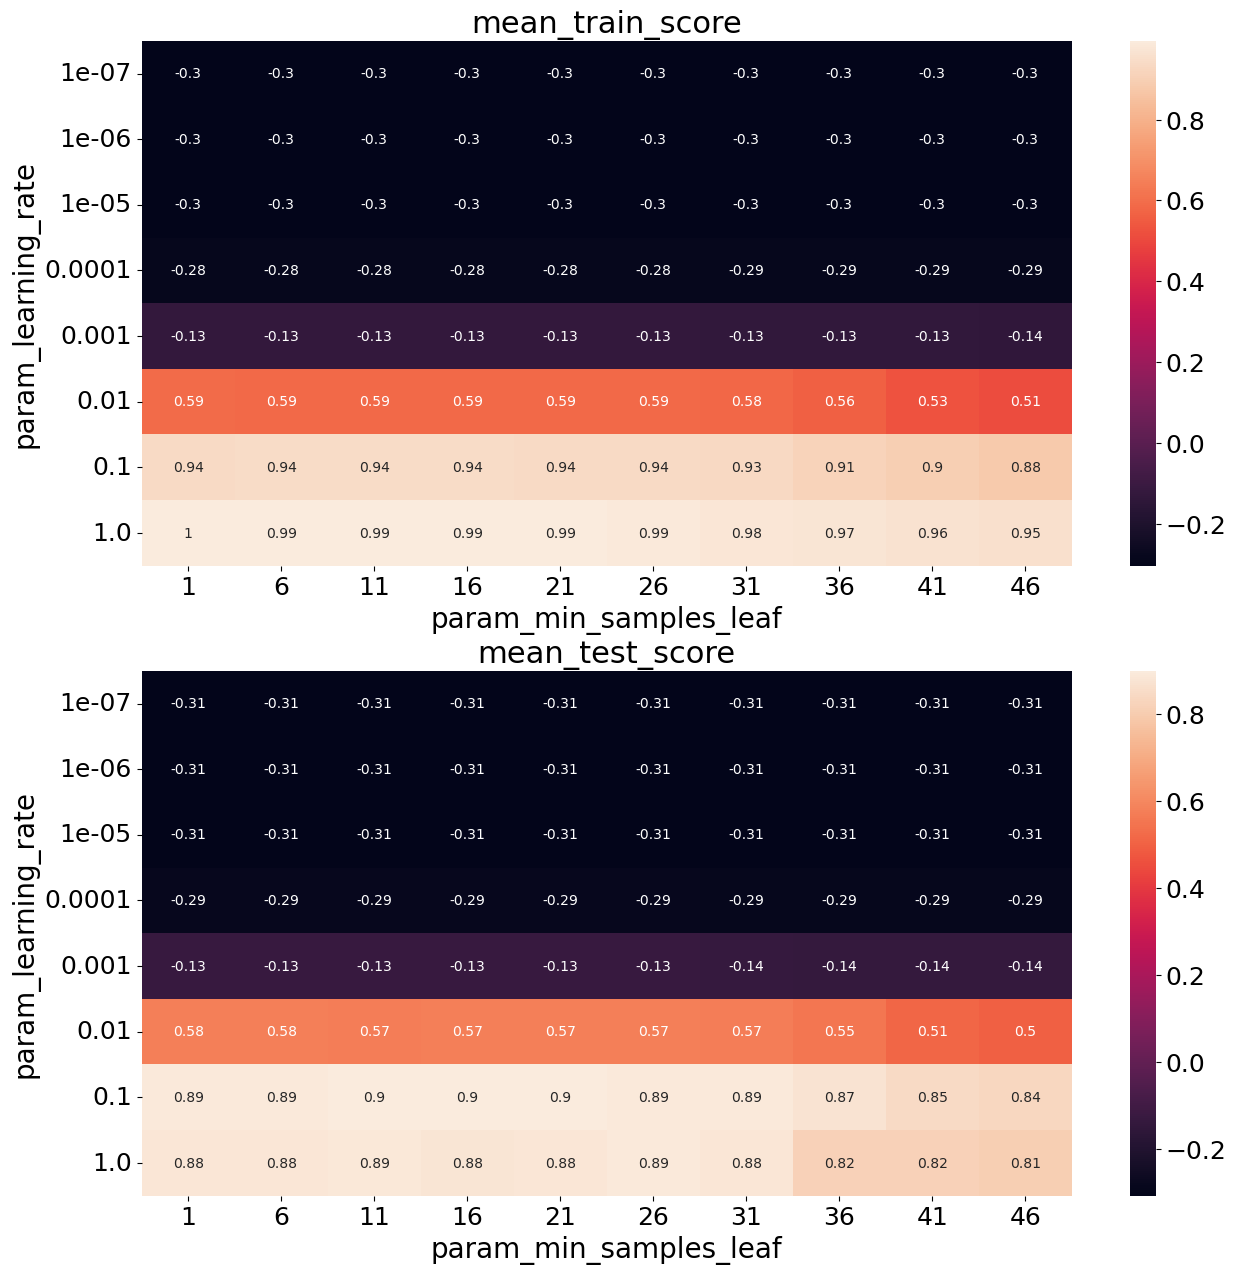

In [41]:
train_data = results[['param_learning_rate', 'param_min_samples_leaf', 'mean_train_score']]
validation_data = results[['param_learning_rate', 'param_min_samples_leaf', 'mean_test_score']]

fig, axes = plt.subplots(2, 1, figsize=(15, 15)) 

sns.heatmap(train_data.pivot(index= 'param_learning_rate',columns= 'param_min_samples_leaf',values= 'mean_train_score'), annot=True , ax=axes[0])
axes[0].set_title('mean_train_score')

sns.heatmap(validation_data.pivot(index= 'param_learning_rate',columns= 'param_min_samples_leaf',values= 'mean_test_score'), annot=True, ax=axes[1])
axes[1].set_title('mean_test_score')

In [35]:
fitted_GBR = grid_search.best_estimator_

fitted_GBR.fit(x_train, y_train)



GradientBoostingRegressor(loss='huber', min_samples_leaf=11)

In [43]:
result = cross_validate(fitted_GBR, x_train, y_train, cv= 5, scoring= 'neg_mean_squared_error' ,return_train_score= True)
train_score = np.mean(result['train_score'])
validation_score = np.mean(result['test_score'])

print(f"Train score: {train_score}")
print(f"Val score: {validation_score}")

Train score: -0.21151285388409385
Val score: -0.3631413459653925


## Section 6: Testing your models

In [ ]:
# from sklearn.metrics import mean_squared_error

# def neg_mean_squared_error_score(estimator, X, y):
#     y_pred = estimator.predict(X)
#     return -mean_squared_error(y, y_pred)

In [48]:
dummy_test_score = fitted_dummy.score(x_test, y_test)
linear_test_score = fitted_linear.score(x_test, y_test)
lasso_test_score = fitted_lasso.score(x_test, y_test)
poly_lasso_test_score = fitted_poly_lasso.score(poly_x_test, poly_y_test)
GBR_test_score = fitted_GBR.score(x_test, y_test)

print(f"Dummy test score: {dummy_test_score}")
print(f"Linear test score: {linear_test_score}")
print(f"Lasso test score: {lasso_test_score}")
print(f"Poly Lasso test score: {poly_lasso_test_score}")
print(f"GBR test score: {GBR_test_score}")


Dummy test score: -0.015127514132835307
Linear test score: 0.317658728456521
Lasso test score: 0.2929683605221657
Poly Lasso test score: -0.014951299221309666
GBR test score: 0.9067442280807773
